In [1]:
zip_path = "/content/Khaleej.zip"
extract_to = "/content/al_khaleej"
import zipfile

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("Extraction terminée !")


Extraction terminée !


# **SVC**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Nombre total de documents chargés : 45500
Répartition par catégorie :
  Culture: 6500
  Finance: 6500
  Medical: 6500
  Politics: 6500
  Religion: 6500
  Sports: 6500
  Tech: 6500

Prétraitement des textes avec suppression des tachkīl...

Vérification du prétraitement:
--------------------------------------------------
Exemple 1:
  Original a 2067 caractères, contient tachkīl: True
  Traité a 1911 caractères, contient tachkīl: False
  ✓ Tachkīl supprimés avec succès

Exemple 2:
  Original a 3838 caractères, contient tachkīl: True
  Traité a 3378 caractères, contient tachkīl: False
  ✓ Tachkīl supprimés avec succès

Exemple 3:
  Original a 989 caractères, contient tachkīl: True
  Traité a 888 caractères, contient tachkīl: False
  ✓ Tachkīl supprimés avec succès


Vectorisation TF-IDF...
Dimensions TF-IDF : (45500, 5000)
Nombre de features : 5000

Données d'entraînement : 36400
Données de test : 9100

ENTRAÎNEMENT DU MODÈLE SVC
Modèle SVC entraîné avec succès.

RÉSULTATS SVC
Accuracy:  0

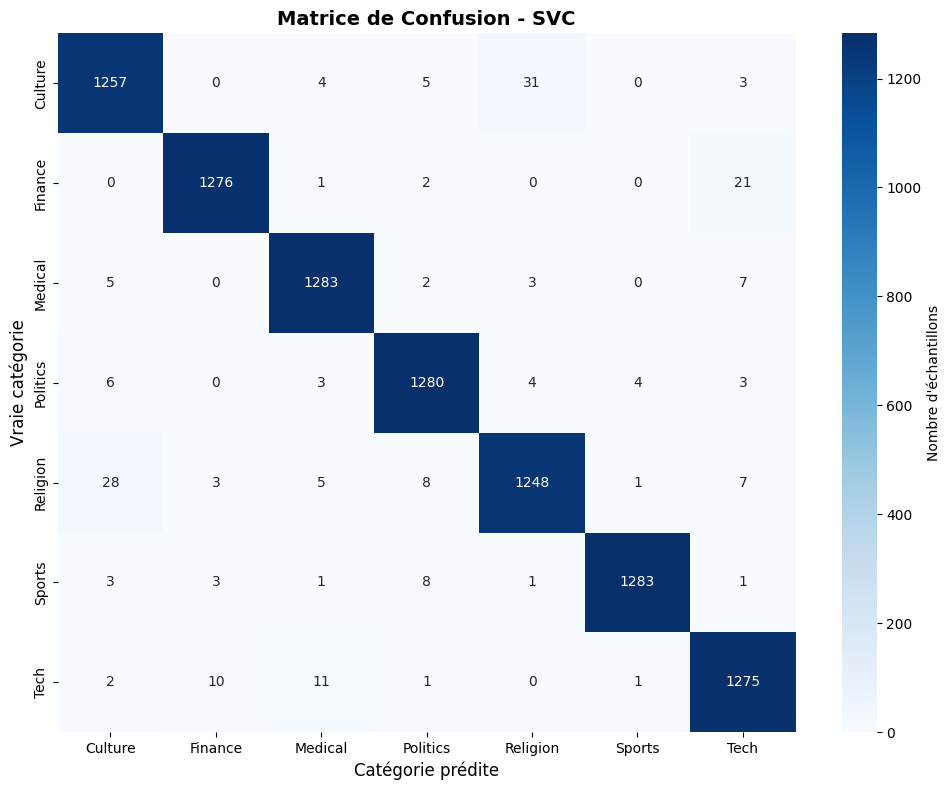


Analyse de la matrice de confusion:
Prédictions correctes: 8902/9100 (97.82%)
Culture: 1257/1300 correct (3.31% erreurs)
Finance: 1276/1300 correct (1.85% erreurs)
Medical: 1283/1300 correct (1.31% erreurs)
Politics: 1280/1300 correct (1.54% erreurs)
Religion: 1248/1300 correct (4.00% erreurs)
Sports: 1283/1300 correct (1.31% erreurs)
Tech: 1275/1300 correct (1.92% erreurs)

EXEMPLES DE PRÉDICTIONS DÉTAILLÉES

Exemple 1:
  Vraie catégorie: Culture
  Prédiction SVC: Culture ✓
  Texte (extrait): قدم البروفيسور الهندي اس دي كارنيكنائب رئيس جامعه مومبي امس الاول ملتقي الادب ضمن فعاليات المعرض محا...

Exemple 2:
  Vraie catégorie: Sports
  Prédiction SVC: Sports ✓
  Texte (extrait): عمت مشاعر الغضب والاستياء جماهير كره القدم سنغافوره اعلان محطتين تليفزيونيتين ان قيمه الاشتراك الخاص...

Exemple 3:
  Vraie catégorie: Sports
  Prédiction SVC: Sports ✓
  Texte (extrait): يواجه ليل المتصدر امتحانا صعبا عندما يحل ضيفا علي مونبيلييه السابع اقوي مباريات المرحله الرابعه والع...

Exemple 4:
  Vraie 

In [2]:
# -*- coding: utf-8 -*-
"""
Algorithme SVC pour la classification de documents arabes avec TF-IDF
Dataset : Al-Khaleej (7 catégories)
Avec suppression des tachkīl et nettoyage complet
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# 1. Téléchargement des stopwords arabes
# ----------------------------
try:
    stop_words = set(stopwords.words('arabic'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('arabic'))

# ----------------------------
# 2. Chargement du dataset Al-Khaleej
# ----------------------------
def load_alkhaleej_dataset(base_path):
    """Charge le dataset Al-Khaleej organisé en dossiers par catégorie."""
    data = []
    labels = []

    categories = ['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']

    for category in categories:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            print(f"Avertissement : Le dossier {category_path} n'existe pas.")
            continue

        for file_name in os.listdir(category_path):
            if file_name.endswith('.txt'):
                file_path = os.path.join(category_path, file_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                        data.append(text)
                        labels.append(category)
                except Exception as e:
                    print(f"Erreur lors de la lecture de {file_path}: {e}")

    print(f"Nombre total de documents chargés : {len(data)}")
    print("Répartition par catégorie :")
    for cat in categories:
        print(f"  {cat}: {labels.count(cat)}")

    return data, labels

# Chemin vers votre dataset
dataset_path = "/content/al_khaleej"
texts, categories = load_alkhaleej_dataset(dataset_path)

# ----------------------------
# 3. PRÉTRAITEMENT COMPLET AVEC SUPPRESSION DES TACHKĪL
# ----------------------------
def remove_tashkil(text):
    """
    Supprime les diacritiques (tachkīl) du texte arabe.
    """
    # Table de mapping pour supprimer les diacritiques
    tashkil_map = {
        # Harakat (voyelles courtes)
        '\u064e': '',  # Fatha (َ)
        '\u064f': '',  # Damma (ُ)
        '\u0650': '',  # Kasra (ِ)
        '\u0651': '',  # Shadda (ّ)
        '\u0652': '',  # Sukun (ْ)
        # Tanwin (nunation)
        '\u064b': '',  # Fathatan (ً)
        '\u064c': '',  # Dammatan (ٌ)
        '\u064d': '',  # Kasratan (ٍ)
        # Autres diacritiques
        '\u0653': '',  # Maddah (آ)
        '\u0654': '',  # Hamza Above (ؤ)
        '\u0655': '',  # Hamza Below (إ)
        '\u0670': '',  # Dagger Alif (ٰ)
    }

    # Appliquer le mapping
    for tashkil, replacement in tashkil_map.items():
        text = text.replace(tashkil, replacement)

    return text

def preprocess_arabic_text(text):
    """
    Prétraitement complet du texte arabe incluant:
    1. Suppression des tachkīl (diacritiques)
    2. Nettoyage des caractères
    3. Normalisation des lettres arabes
    4. Suppression des stopwords
    """
    # Étape 1: Supprimer les tachkīl (diacritiques)
    text = remove_tashkil(text)

    # Étape 2: Nettoyage des caractères
    # Supprimer les caractères non-arabes (conserver les espaces)
    text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)

    # Étape 3: Normalisation des lettres arabes
    # Normaliser les différentes formes de Alif
    text = re.sub(r'[آأإ]', 'ا', text)

    # Normaliser Teh Marbuta à Heh
    text = re.sub(r'[ة]', 'ه', text)

    # Normaliser Alif Maqsura à Yeh
    text = re.sub(r'[ى]', 'ي', text)

    # Étape 4: Supprimer les chiffres
    text = re.sub(r'\d+', ' ', text)

    # Étape 5: Nettoyage des espaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Étape 6: Tokenization et suppression des stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Étape 7: Filtrer les mots trop courts (optionnel)
    words = [word for word in words if len(word) > 1]

    return ' '.join(words)

print("\nPrétraitement des textes avec suppression des tachkīl...")
cleaned_texts = [preprocess_arabic_text(text) for text in texts]

# ----------------------------
# 4. Vérification du prétraitement
# ----------------------------
def check_tashkil_removal(original_text, processed_text):
    """Affiche un exemple avant/après prétraitement."""
    tashkil_chars = ['\u064e', '\u064f', '\u0650', '\u0651', '\u0652',
                     '\u064b', '\u064c', '\u064d']

    original_has_tashkil = any(char in original_text for char in tashkil_chars)
    processed_has_tashkil = any(char in processed_text for char in tashkil_chars)

    return original_has_tashkil, processed_has_tashkil

# Tester sur quelques exemples
print("\nVérification du prétraitement:")
print("-" * 50)
for i in range(min(3, len(texts))):
    orig_has, proc_has = check_tashkil_removal(texts[i], cleaned_texts[i])
    print(f"Exemple {i+1}:")
    print(f"  Original a {len(texts[i])} caractères, contient tachkīl: {orig_has}")
    print(f"  Traité a {len(cleaned_texts[i])} caractères, contient tachkīl: {proc_has}")
    if orig_has and not proc_has:
        print("  ✓ Tachkīl supprimés avec succès")
    print()

# ----------------------------
# 5. Vectorisation TF-IDF
# ----------------------------
print("\nVectorisation TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    analyzer='word'
)
X = vectorizer.fit_transform(cleaned_texts)
y = categories

print(f"Dimensions TF-IDF : {X.shape}")
print(f"Nombre de features : {len(vectorizer.get_feature_names_out())}")

# ----------------------------
# 6. Séparation des données
# ----------------------------
# Create an array of original indices to split along with X and y
original_indices = np.arange(len(cleaned_texts))

X_train, X_test, y_train, y_test, train_original_indices, test_original_indices = train_test_split(
    X, y, original_indices,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nDonnées d'entraînement : {X_train.shape[0]}")
print(f"Données de test : {X_test.shape[0]}")

# ----------------------------
# 7. Entraînement du modèle SVC
# ----------------------------
print("\n" + "="*50)
print("ENTRAÎNEMENT DU MODÈLE SVC")
print("="*50)

svc_model = SVC(
    kernel='rbf',   # par défaut
    C=1.0,
    gamma='scale',
    random_state=42
)

svc_model.fit(X_train, y_train)
print("Modèle SVC entraîné avec succès.")



# ----------------------------
# 9. Prédictions et évaluation
# ----------------------------
y_pred = svc_model.predict(X_test)

# Métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*50)
print("RÉSULTATS SVC")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred))

# ----------------------------
# 10. Matrice de confusion
# ----------------------------
def plot_confusion_matrix():
    """Affiche la matrice de confusion."""
    classes = sorted(set(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Nombre d\'échantillons'})

    plt.title('Matrice de Confusion - SVC', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie catégorie', fontsize=12)
    plt.xlabel('Catégorie prédite', fontsize=12)
    plt.tight_layout()
    plt.savefig('svc_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Afficher les statistiques de la matrice
    print("\nAnalyse de la matrice de confusion:")
    total_samples = np.sum(cm)
    correct_predictions = np.sum(np.diag(cm))
    accuracy_from_cm = correct_predictions / total_samples
    print(f"Prédictions correctes: {correct_predictions}/{total_samples} ({accuracy_from_cm:.2%})")

    # Afficher les erreurs par classe
    for i, class_name in enumerate(classes):
        total_class = np.sum(cm[i, :])
        correct_class = cm[i, i]
        error_rate = 1 - (correct_class / total_class) if total_class > 0 else 0
        print(f"{class_name}: {correct_class}/{total_class} correct ({error_rate:.2%} erreurs)")

plot_confusion_matrix()



# ----------------------------
# 12. Exemple de prédictions
# ----------------------------
print("\n" + "="*50)
print("EXEMPLES DE PRÉDICTIONS DÉTAILLÉES")
print("="*50)

# Sélectionner 5 exemples aléatoires
sample_indices = np.random.choice(len(y_test), 5, replace=False)

for i, idx_in_test_set in enumerate(sample_indices, 1):
    true_label = y_test[idx_in_test_set]
    predicted_label = y_pred[idx_in_test_set]

    # Obtenir l'index de la vraie classe
    true_idx = list(svc_model.classes_).index(true_label) if true_label in svc_model.classes_ else -1

    # Obtenir la décision (distance au hyperplan) si disponible
    try:
        # Pour SVC linéaire, on peut obtenir les distances de décision
        decision_values = svc_model.decision_function(X_test[idx_in_test_set])
        if true_idx != -1:
            confidence = decision_values[true_idx]
        else:
            confidence = np.max(decision_values)
        confidence_str = f" (confiance: {confidence:.3f})"
    except:
        confidence_str = ""

    is_correct = "✓" if true_label == predicted_label else "✗"

    print(f"\nExemple {i}:")
    print(f"  Vraie catégorie: {true_label}")
    print(f"  Prédiction SVC: {predicted_label} {is_correct}{confidence_str}")

    # Afficher un extrait du texte original (nettoyé)
    # Use the stored test_original_indices to map back to the cleaned_texts
    original_idx = test_original_indices[idx_in_test_set]
    if original_idx < len(cleaned_texts):
        text_preview = cleaned_texts[original_idx]
        preview = text_preview[:100] + "..." if len(text_preview) > 100 else text_preview
        print(f"  Texte (extrait): {preview}")



# ----------------------------
# 14. Sauvegarde des résultats
# ----------------------------
print("\n" + "="*50)
print("RÉSUMÉ DES RÉSULTATS")
print("="*50)

# Créer un DataFrame avec tous les résultats
results_summary = {
    'Dataset': 'Al-Khaleej',
    'Algorithme': 'SVC',
    'Kernel': 'linéaire',
    'C': 1.0,
    'TF-IDF Features': X.shape[1],
    'Documents totaux': len(texts),
    'Train size': X_train.shape[0],
    'Test size': X_test.shape[0],
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Classes': len(set(categories)),
    'Tashkil_Supprimés': True,
    'Stopwords_Supprimés': True,
    'Normalisation': True
}

results_df = pd.DataFrame([results_summary])
print("\nRésumé des résultats:")
print(results_df.to_string(index=False))

# Sauvegarder dans un fichier
results_df.to_csv('svc_results_summary.csv', index=False)
print("\nRésultats sauvegardés dans 'svc_results_summary.csv'")

print("\n" + "="*50)
print("TRAITEMENT TERMINÉ AVEC SUCCÈS!")
print("="*50)


# **SGD**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Nombre total de documents chargés : 45500
Répartition par catégorie :
  Culture: 6500
  Finance: 6500
  Medical: 6500
  Politics: 6500
  Religion: 6500
  Sports: 6500
  Tech: 6500

Prétraitement des textes avec suppression des tachkīl...

Vérification du prétraitement:
--------------------------------------------------
Exemple 1:
  Original a 615 caractères, contient tachkīl: True
  Traité a 522 caractères, contient tachkīl: False
  ✓ Tachkīl supprimés avec succès

Exemple 2:
  Original a 1900 caractères, contient tachkīl: True
  Traité a 1717 caractères, contient tachkīl: False
  ✓ Tachkīl supprimés avec succès

Exemple 3:
  Original a 2715 caractères, contient tachkīl: True
  Traité a 2315 caractères, contient tachkīl: False
  ✓ Tachkīl supprimés avec succès


Vectorisation TF-IDF...
Dimensions TF-IDF : (45500, 5000)
Nombre de features : 5000

Données d'entraînement : 36400
Données de test : 9100

ENTRAÎNEMENT DU MODÈLE SGDClassifier
Modèle SGDClassifier entraîné avec succès.

RÉSULT

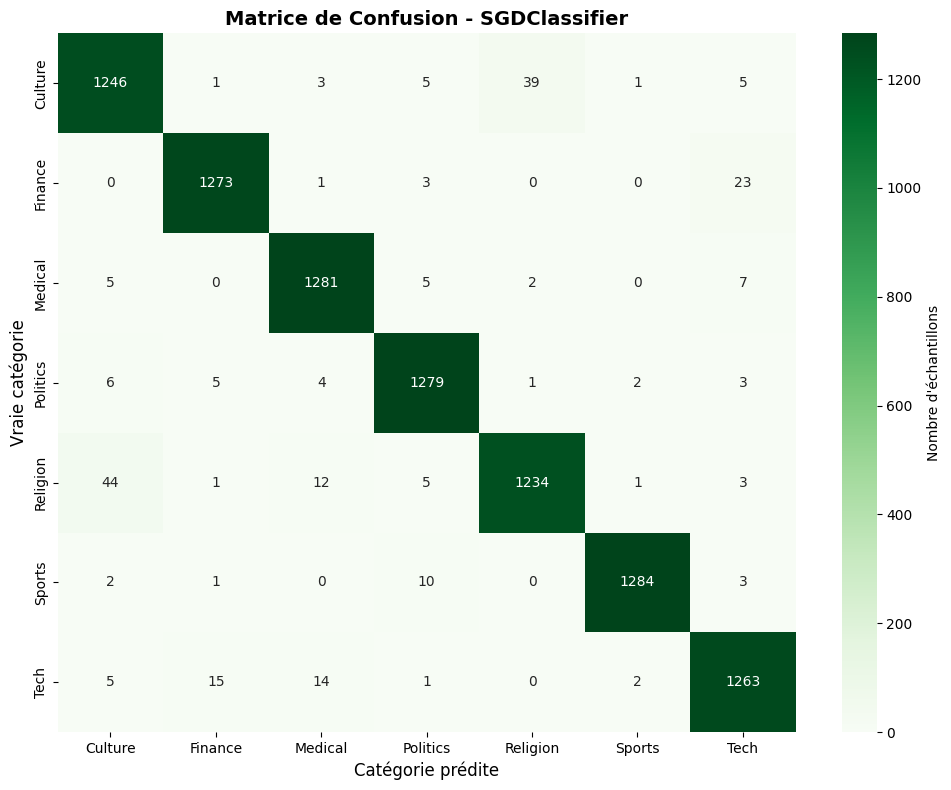


EXEMPLES DE PRÉDICTIONS DÉTAILLÉES

Exemple 1:
  Vraie catégorie: Medical
  Prédiction SGD: Medical ✓
  Texte (extrait): دبي الخليج حققت مبادره خذ قرار انجازا مسبوق علي صعيد حملات التوعيه بحاله السكري دوله الامارات العربي...

Exemple 2:
  Vraie catégorie: Sports
  Prédiction SGD: Sports ✓
  Texte (extrait): يزال البرازيلي جواو ميراندا لاعب اتلتيكو مدريد الاسباني حائرا يخص مستقبله الفتره المقبله ناديه الحال...

Exemple 3:
  Vraie catégorie: Culture
  Prédiction SGD: Culture ✓
  Texte (extrait): نظم معهد الشارقه للفنون التابع لمجمع الشارقه للاداب والفنون، ورشه بعنوان دائره الالوان اشرفت عليها ا...

Exemple 4:
  Vraie catégorie: Politics
  Prédiction SGD: Politics ✓
  Texte (extrait): اكد نواب عماليون ان رئيس الوزراء البريطاني السابق توني بلير ارغم علي الاستقاله العام الماضي، بسبب دو...

Exemple 5:
  Vraie catégorie: Politics
  Prédiction SGD: Politics ✓
  Texte (extrait): افاد متحدث باسم وزاره الدفاع العراقيه، امس الاثنين، بان القوات الامريكيه تواصل انسحابها العراق وتسلي...

RÉSUMÉ DES 

In [ ]:
# -*- coding: utf-8 -*-
"""
Algorithme SVC pour la classification de documents arabes avec TF-IDF
Dataset : Al-Khaleej (7 catégories)
Avec suppression des tachkīl et nettoyage complet
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# 1. Téléchargement des stopwords arabes
# ----------------------------
try:
    stop_words = set(stopwords.words('arabic'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('arabic'))

# ----------------------------
# 2. Chargement du dataset Al-Khaleej
# ----------------------------
def load_alkhaleej_dataset(base_path):
    """Charge le dataset Al-Khaleej organisé en dossiers par catégorie."""
    data = []
    labels = []

    categories = ['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']

    for category in categories:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            print(f"Avertissement : Le dossier {category_path} n'existe pas.")
            continue

        for file_name in os.listdir(category_path):
            if file_name.endswith('.txt'):
                file_path = os.path.join(category_path, file_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                        data.append(text)
                        labels.append(category)
                except Exception as e:
                    print(f"Erreur lors de la lecture de {file_path}: {e}")

    print(f"Nombre total de documents chargés : {len(data)}")
    print("Répartition par catégorie :")
    for cat in categories:
        print(f"  {cat}: {labels.count(cat)}")

    return data, labels

# Chemin vers votre dataset
dataset_path = "/content/al_khaleej"
texts, categories = load_alkhaleej_dataset(dataset_path)

# ----------------------------
# 3. PRÉTRAITEMENT COMPLET AVEC SUPPRESSION DES TACHKĪL
# ----------------------------
def remove_tashkil(text):
    """
    Supprime les diacritiques (tachkīl) du texte arabe.
    """
    # Table de mapping pour supprimer les diacritiques
    tashkil_map = {
        # Harakat (voyelles courtes)
        '\u064e': '',  # Fatha (َ)
        '\u064f': '',  # Damma (ُ)
        '\u0650': '',  # Kasra (ِ)
        '\u0651': '',  # Shadda (ّ)
        '\u0652': '',  # Sukun (ْ)
        # Tanwin (nunation)
        '\u064b': '',  # Fathatan (ً)
        '\u064c': '',  # Dammatan (ٌ)
        '\u064d': '',  # Kasratan (ٍ)
        # Autres diacritiques
        '\u0653': '',  # Maddah (آ)
        '\u0654': '',  # Hamza Above (ؤ)
        '\u0655': '',  # Hamza Below (إ)
        '\u0670': '',  # Dagger Alif (ٰ)
    }

    # Appliquer le mapping
    for tashkil, replacement in tashkil_map.items():
        text = text.replace(tashkil, replacement)

    return text

def preprocess_arabic_text(text):
    """
    Prétraitement complet du texte arabe incluant:
    1. Suppression des tachkīl (diacritiques)
    2. Nettoyage des caractères
    3. Normalisation des lettres arabes
    4. Suppression des stopwords
    """
    # Étape 1: Supprimer les tachkīl (diacritiques)
    text = remove_tashkil(text)

    # Étape 2: Nettoyage des caractères
    # Supprimer les caractères non-arabes (conserver les espaces)
    text = re.sub(r'[^؀-\u06FF\s]', ' ', text)

    # Étape 3: Normalisation des lettres arabes
    # Normaliser les différentes formes de Alif
    text = re.sub(r'[آأإ]', 'ا', text)

    # Normaliser Teh Marbuta à Heh
    text = re.sub(r'[ة]', 'ه', text)

    # Normaliser Alif Maqsura à Yeh
    text = re.sub(r'[ى]', 'ي', text)

    # Étape 4: Supprimer les chiffres
    text = re.sub(r'\d+', ' ', text)

    # Étape 5: Nettoyage des espaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Étape 6: Tokenization et suppression des stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Étape 7: Filtrer les mots trop courts (optionnel)
    words = [word for word in words if len(word) > 1]

    return ' '.join(words)

print("\nPrétraitement des textes avec suppression des tachkīl...")
cleaned_texts = [preprocess_arabic_text(text) for text in texts]

# ----------------------------
# 4. Vérification du prétraitement
# ----------------------------
def check_tashkil_removal(original_text, processed_text):
    """Affiche un exemple avant/après prétraitement."""
    tashkil_chars = ['\u064e', '\u064f', '\u0650', '\u0651', '\u0652',
                     '\u064b', '\u064c', '\u064d']

    original_has_tashkil = any(char in original_text for char in tashkil_chars)
    processed_has_tashkil = any(char in processed_text for char in tashkil_chars)

    return original_has_tashkil, processed_has_tashkil

# Tester sur quelques exemples
print("\nVérification du prétraitement:")
print("-" * 50)
for i in range(min(3, len(texts))):
    orig_has, proc_has = check_tashkil_removal(texts[i], cleaned_texts[i])
    print(f"Exemple {i+1}:")
    print(f"  Original a {len(texts[i])} caractères, contient tachkīl: {orig_has}")
    print(f"  Traité a {len(cleaned_texts[i])} caractères, contient tachkīl: {proc_has}")
    if orig_has and not proc_has:
        print("  ✓ Tachkīl supprimés avec succès")
    print()

# ----------------------------
# 5. Vectorisation TF-IDF
# ----------------------------
print("\nVectorisation TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    analyzer='word'
)
X = vectorizer.fit_transform(cleaned_texts)
y = categories

print(f"Dimensions TF-IDF : {X.shape}")
print(f"Nombre de features : {len(vectorizer.get_feature_names_out())}")

# ----------------------------
# 6. Séparation des données
# ----------------------------
# Create an array of original indices to split along with X and y
original_indices = np.arange(len(cleaned_texts))

X_train, X_test, y_train, y_test, train_original_indices, test_original_indices = train_test_split(
    X, y, original_indices,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nDonnées d'entraînement : {X_train.shape[0]}")
print(f"Données de test : {X_test.shape[0]}")

# ----------------------------
# 8. ENTRAÎNEMENT DU MODÈLE SGDClassifier
# ----------------------------
print("\n" + "="*50)
print("ENTRAÎNEMENT DU MODÈLE SGDClassifier")
print("="*50)

sgd_model = SGDClassifier(
    loss='hinge',          # SVM linéaire
    penalty='l2',
    alpha=1e-4,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

sgd_model.fit(X_train, y_train)
print("Modèle SGDClassifier entraîné avec succès.")


# ----------------------------
# 9. Prédictions et évaluation SGD
# ----------------------------
y_pred_sgd = sgd_model.predict(X_test)

# Métriques
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
precision_sgd = precision_score(y_test, y_pred_sgd, average='weighted')
recall_sgd = recall_score(y_test, y_pred_sgd, average='weighted')
f1_sgd = f1_score(y_test, y_pred_sgd, average='weighted')

print("\n" + "="*50)
print("RÉSULTATS SGDClassifier")
print("="*50)
print(f"Accuracy:  {accuracy_sgd:.4f}")
print(f"Precision: {precision_sgd:.4f}")
print(f"Recall:    {recall_sgd:.4f}")
print(f"F1-Score:  {f1_sgd:.4f}")

print("\nRapport de classification détaillé (SGD):")
print(classification_report(y_test, y_pred_sgd))

# ----------------------------
# 10. Matrice de confusion SGD
# ----------------------------
def plot_confusion_matrix_sgd():
    """Affiche la matrice de confusion pour SGDClassifier."""
    classes = sorted(set(y_test))
    cm = confusion_matrix(y_test, y_pred_sgd, labels=classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Nombre d\'échantillons'})

    plt.title('Matrice de Confusion - SGDClassifier', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie catégorie', fontsize=12)
    plt.xlabel('Catégorie prédite', fontsize=12)
    plt.tight_layout()
    plt.savefig('sgd_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Appel :
plot_confusion_matrix_sgd()


# ----------------------------
# 12. Exemple de prédictions
# ----------------------------
print("\n" + "="*50)
print("EXEMPLES DE PRÉDICTIONS DÉTAILLÉES")
print("="*50)

# Sélectionner 5 exemples aléatoires
sample_indices = np.random.choice(len(y_test), 5, replace=False)

for i, idx_in_test_set in enumerate(sample_indices, 1):
    true_label = y_test[idx_in_test_set]
    predicted_label = y_pred_sgd[idx_in_test_set] # Changed from y_pred to y_pred_sgd

    # Obtenir l'index de la vraie classe
    true_idx = list(sgd_model.classes_).index(true_label) if true_label in sgd_model.classes_ else -1 # Changed SGD_model and sGD_model to sgd_model

    # Obtenir la décision (distance au hyperplan) si disponible
    try:
        # Pour SGD linéaire, on peut obtenir les distances de décision
        decision_values = sgd_model.decision_function(X_test[idx_in_test_set]) # Changed SGD_model to sgd_model
        if true_idx != -1:
            confidence = decision_values[true_idx]
        else:
            confidence = np.max(decision_values)
        confidence_str = f" (confiance: {confidence:.3f})"
    except:
        confidence_str = ""

    is_correct = "✓" if true_label == predicted_label else "✗"

    print(f"\nExemple {i}:")
    print(f"  Vraie catégorie: {true_label}")
    print(f"  Prédiction SGD: {predicted_label} {is_correct}{confidence_str}")

    # Afficher un extrait du texte original (nettoyé)
    # Use the stored test_original_indices to map back to the cleaned_texts
    original_idx = test_original_indices[idx_in_test_set]
    if original_idx < len(cleaned_texts):
        text_preview = cleaned_texts[original_idx]
        preview = text_preview[:100] + "..." if len(text_preview) > 100 else text_preview
        print(f"  Texte (extrait): {preview}")



# ----------------------------
# 14. Sauvegarde des résultats
# ----------------------------
print("\n" + "="*50)
print("RÉSUMÉ DES RÉSULTATS")
print("="*50)

# Créer un DataFrame avec tous les résultats
results_summary = {
    'Dataset': 'Al-Khaleej',
    'Algorithme': 'SGD',
    'Kernel': 'linéaire',
    'C': 1.0,
    'TF-IDF Features': X.shape[1],
    'Documents totaux': len(texts),
    'Train size': X_train.shape[0],
    'Test size': X_test.shape[0],
    'Accuracy': accuracy_sgd, # Changed accuracy to accuracy_sgd
    'Precision': precision_sgd, # Changed precision to precision_sgd
    'Recall': recall_sgd, # Changed recall to recall_sgd
    'F1-Score': f1_sgd, # Changed f1 to f1_sgd
    'Classes': len(set(categories)),
    'Tashkil_Supprimés': True,
    'Stopwords_Supprimés': True,
    'Normalisation': True
}

results_df = pd.DataFrame([results_summary])
print("\nRésumé des résultats:")
print(results_df.to_string(index=False))

# Sauvegarder dans un fichier
results_df.to_csv('sgd_results_summary.csv', index=False) # Changed sGD_results_summary.csv to sgd_results_summary.csv
print("\nRésultats sauvegardés dans 'sgd_results_summary.csv'") # Changed SGD_results_summary.csv to sgd_results_summary.csv

print("\n" + "="*50)
print("TRAITEMENT TERMINÉ AVEC SUCCÈS!")
print("="*50)


In [ ]:
# ----------------------------
# SAUVEGARDE DU MODÈLE
# ----------------------------
import joblib

# Sauvegarde du modèle SGD
joblib.dump(sgd_model, 'SGD_arabic_model.pkl')
print("✓ Modèle SGD sauvegardé: SGD_arabic_model.pkl")

# Sauvegarde du vectorizer TF-IDF
joblib.dump(vectorizer, 'tfidf_vectorizer_sgd.pkl')
print("✓ Vectorizer TF-IDF sauvegardé: tfidf_vectorizer_sgd.pkl")

# Optionnel : Sauvegarde des résultats dans un CSV
results_df = pd.DataFrame([{
    'Accuracy': accuracy_sgd,
    'Precision': precision_sgd,
    'Recall': recall_sgd,
    'F1-Score': f1_sgd
}])

results_df.to_csv('sgd_results.csv', index=False, encoding='utf-8')
print("✓ Résultats sauvegardés: sgd_results.csv")


✓ Modèle SGD sauvegardé: SGD_arabic_model.pkl
✓ Vectorizer TF-IDF sauvegardé: tfidf_vectorizer_sgd.pkl
✓ Résultats sauvegardés: sgd_results.csv


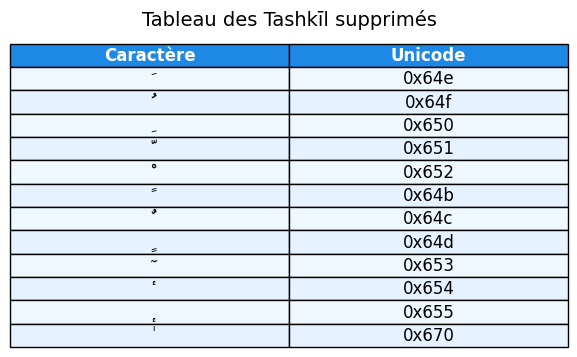

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Liste des caractères Tashkīl
tashkil_chars = [
    '\u064e', '\u064f', '\u0650', '\u0651', '\u0652',
    '\u064b', '\u064c', '\u064d', '\u0653', '\u0654',
    '\u0655', '\u0670'
]

df_tashkil = pd.DataFrame({
    "Caractère": tashkil_chars,
    "Unicode": [hex(ord(c)) for c in tashkil_chars]
})

# --- Visualisation Matplotlib ---
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')  # cacher axes

table = ax.table(
    cellText=df_tashkil.values,
    colLabels=df_tashkil.columns,
    loc='center',
    cellLoc='center'
)

# Style du tableau
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)

# Coloration des lignes du tableau
for i in range(len(df_tashkil)):
    color = "#f0f8ff" if i % 2 == 0 else "#e6f2ff"
    table[i+1, 0].set_facecolor(color)
    table[i+1, 1].set_facecolor(color)

# En-têtes colorés
for j in range(2):
    table[0, j].set_facecolor("#1e88e5")
    table[0, j].set_text_props(color="white", weight="bold")

plt.title("Tableau des Tashkīl supprimés", fontsize=14, y=1.2)
plt.show()


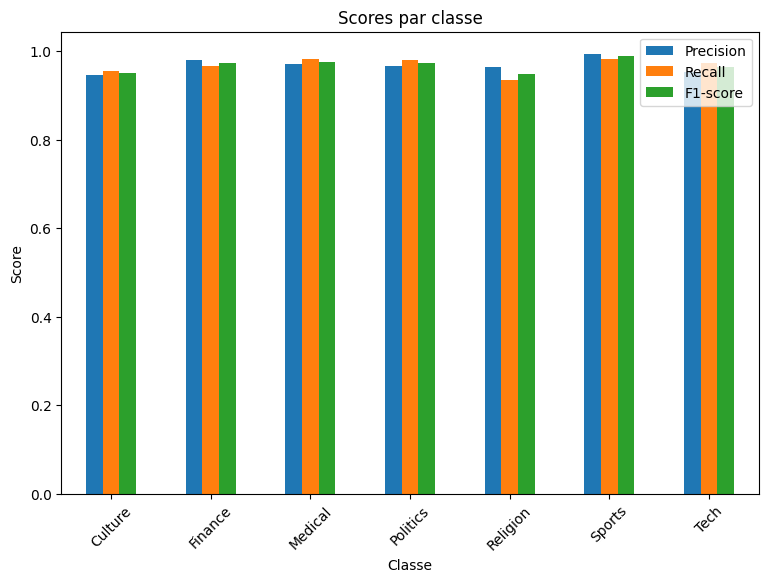

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1_cls, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=model.classes_
)

df_scores = pd.DataFrame({
    "Classe": model.classes_,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1_cls
})

df_scores.plot(x="Classe", kind="bar", figsize=(9,6))
plt.title("Scores par classe")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


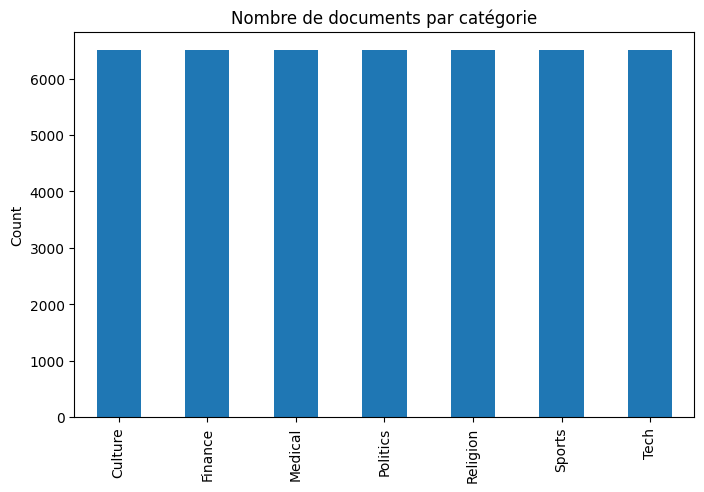

In [ ]:
pd.Series(categories).value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Nombre de documents par catégorie")
plt.ylabel("Count")
plt.show()
